In [9]:
from tensorflow import reshape
from tensorflow.python.keras import Input
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import LeakyReLU, Dense, Dropout, MaxPooling1D, Conv1D, Flatten, concatenate
from tensorflow.python.keras.metrics import Precision, Recall
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.regularizers import L1L2, L2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

"""
    Creates models consisting of two autoencoders and a CNN
"""

def trainSAE_CNN(x_train_norm, x_train_mal, x_train, y_train, nb_epoch_cnn, nb_epoch_sae, batch_size_cnn, batch_size_sae, datenow):
    print(x_train.shape[1])
    input_dim = x_train.shape[1]
    act_reg = L1L2()
    act = LeakyReLU()
    hidden_dim_1 = input_dim
    hidden_dim_2 = input_dim
    optimizer = Adam()  # learning_rate=0.001)

    filter1 = 32
    filter2 = 64
    filter3 = 128

    # Autoencoder Normal
    input_layer_aen = Input(shape=(input_dim,))
    encoder_norm = Dense(hidden_dim_1, activation=act, use_bias=False, activity_regularizer=act_reg, name="hl_norm1")(
        input_layer_aen)
    encoder_norm = BatchNormalization()(encoder_norm)
    encoder_norm = Dropout(0.5)(encoder_norm)

    encoder_norm = Dense(hidden_dim_2, activation=act, use_bias=False, activity_regularizer=act_reg, name="hl_norm2")(
        encoder_norm)
    encoder_norm = BatchNormalization()(encoder_norm)
    encoder_norm = Dropout(0.5)(encoder_norm)

    decoder_norm = Dense(hidden_dim_1, activation=act, activity_regularizer=act_reg)(encoder_norm)  # or softmax
    decoder_norm = BatchNormalization()(decoder_norm)
    decoder_norm = Dropout(0.5)(decoder_norm)

    decoder_norm = Dense(input_dim, activation='sigmoid')(decoder_norm)  # or softmax

    autoencoder_norm = Model(inputs=input_layer_aen, outputs=decoder_norm, name="ae_norm")

    # Autoencoder Malicious
    input_layer_aem = Input(shape=(input_dim,))
    encoder_mal = Dense(hidden_dim_1, activation=act, use_bias=False, activity_regularizer=act_reg, name="hl_mal1")(
        input_layer_aem)
    encoder_mal = BatchNormalization()(encoder_mal)
    encoder_mal = Dropout(0.5)(encoder_mal)

    encoder_mal = Dense(hidden_dim_2, activation=act, use_bias=False, activity_regularizer=act_reg, name="hl_mal2")(
        encoder_mal)
    encoder_mal = BatchNormalization()(encoder_mal)
    encoder_mal = Dropout(0.5)(encoder_mal)

    decoder_mal = Dense(hidden_dim_1, activation=act, activity_regularizer=act_reg)(encoder_mal)  # or softmax
    decoder_mal = BatchNormalization()(decoder_mal)
    decoder_mal = Dropout(0.5)(decoder_mal)

    decoder_mal = Dense(input_dim, activation='sigmoid')(decoder_mal)  # or softmax

    autoencoder_mal = Model(inputs=input_layer_aem, outputs=decoder_mal, name="ae_mal")

    # compilation of AE_normal + AE_mal
    autoencoder_norm.compile(metrics=['accuracy', Precision(), Recall()], loss='mse', optimizer=optimizer)
    autoencoder_norm.summary()

    autoencoder_mal.compile(metrics=['accuracy', Precision(), Recall()], loss='mse', optimizer=optimizer)
    autoencoder_mal.summary()

    history_norm = autoencoder_norm.fit(x_train_norm, x_train_norm, epochs=nb_epoch_sae, batch_size=batch_size_sae,
                                        # validation_data=(x_test_norm, x_test_norm),
                                        # callbacks=[EarlyStopping(monitor="val_loss", patience=25, mode="min")]
                                        callbacks=[EarlyStopping(monitor="accuracy", patience=25, mode="max")]
                                        )

    history_mal = autoencoder_mal.fit(x_train_mal, x_train_mal, epochs=nb_epoch_sae, batch_size=batch_size_sae,
                                      # validation_data=(x_test_mal, x_test_mal),
                                      # callbacks=[EarlyStopping(monitor="val_loss", patience=25, mode="min")]
                                      callbacks=[EarlyStopping(monitor="accuracy", patience=25, mode="max")]
                                      )

    inp = Input(shape=(input_dim,))

    ae_norm_output = autoencoder_norm(inp)
    ae_mal_output = autoencoder_mal(inp)

    # concat_layer = concatenate([autoencoder_norm.get_layer(name="hl_norm2").output, autoencoder_mal.get_layer(name="hl_mal2").output], axis=-1)
    concat_layer = concatenate([ae_norm_output, ae_mal_output], axis=-1)
    concat_layer2 = reshape(concat_layer, [-1, concat_layer.shape[1], 1])

    # CNN
    y = Conv1D(filter1, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal', input_shape=[input_dim, 1])(
        concat_layer2)  # kernel_initializer=’he_normal’
    y = Conv1D(filter1, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal')(y)
    y = MaxPooling1D(2, 2)(y)
    y = Dropout(0.5)(y)

    y = Conv1D(filter2, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal')(y)
    y = Conv1D(filter2, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal')(y)
    y = MaxPooling1D(2, 2)(y)
    # y = BatchNormalization(y)
    y = Dropout(0.5)(y)

    y = Conv1D(filter3, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal')(y)
    y = Conv1D(filter3, 1, activation=act, activity_regularizer=act_reg, kernel_regularizer=L2(),
               kernel_initializer='he_normal')(y)
    y = MaxPooling1D(2, 2)(y)
    y = Dropout(0.5)(y)

    y = Flatten()(y)
    y = Dense(512)(y)
    outputs = Dense(1, activation='sigmoid')(y)

    # cnn = Model(inputs=[input_layer_aen, input_layer_aem], outputs=outputs)
    cnn = Model(inputs=inp, outputs=outputs)

    cnn.compile(metrics=['accuracy', Precision(), Recall()], optimizer=optimizer, loss='binary_crossentropy')
    cnn.summary()

    print("CNN training")
    history_cnn = cnn.fit(x=x_train, y=y_train, epochs=nb_epoch_cnn, shuffle=True, batch_size=batch_size_cnn,
                          # validation_data=(x_test, y_test),
                          # callbacks=[EarlyStopping(monitor="val_loss", patience=25, mode="min")])
                          callbacks=[EarlyStopping(monitor="accuracy", patience=int(nb_epoch_cnn / 2), mode="max")])

    print("Saving")

    cnn.save('./saved_models/sae_cnn_{}'.format(datenow.strftime("%Y-%m-%d_%H-%M-%S")))

    plot_model(cnn, to_file='./saved_models/model_sae_cnn_{}.png'.format(datenow.strftime("%Y-%m-%d_%H-%M-%S")),
               show_shapes=True, show_layer_names=True, expand_nested=True)

    return cnn

In [10]:
import pandas as pd

train_data = pd.read_csv('./datasets/Botnet_Train.csv', delimiter=",")
train_data.drop(columns=['ip.session_id', 'meta.direction'], inplace=True)

test_data = pd.read_csv('./datasets/Botnet_Test.csv', delimiter=",")
test_data.drop(columns=['ip.session_id', 'meta.direction'], inplace=True)

# reading the csv file
print("Shape of the training data: %s" % str(train_data.shape))
print("Training labels: %s" % (train_data['malware'].value_counts()))

print("Shape of the testing data: %s" % str(test_data.shape))
print("Testing labels: %s" % (test_data['malware'].value_counts()))

Shape of the training data: (31704, 60)
Training labels: 1    15852
0    15852
Name: malware, dtype: int64
Shape of the testing data: (13586, 60)
Testing labels: 1    6793
0    6793
Name: malware, dtype: int64


59
Model: "ae_norm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
hl_norm1 (Dense)             (None, 59)                3481      
_________________________________________________________________
tf.cast_6 (TFOpLambda)       (None, 59)                0         
_________________________________________________________________
tf.math.multiply_6 (TFOpLamb (None, 59)                0         
_________________________________________________________________
tf.__operators__.add_6 (TFOp (None, 59)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 59)                0         
_________________________________________________________________
hl_norm2 (Dense)             (None, 59)                3

INFO:tensorflow:Assets written to: ./saved_models/sae_cnn_2023-02-27_16-56-57/assets


INFO:tensorflow:Assets written to: ./saved_models/sae_cnn_2023-02-27_16-56-57/assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Prediction - test
Metrics
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6793
         1.0       1.00      1.00      1.00      6793

    accuracy                           1.00     13586
   macro avg       1.00      1.00      1.00     13586
weighted avg       1.00      1.00      1.00     13586



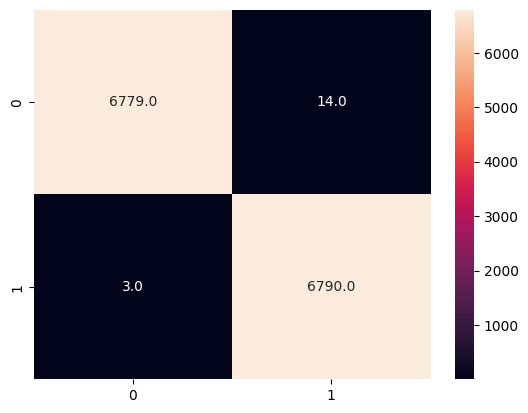

In [13]:
import pickle
from datetime import datetime
import numpy
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import sys

#sys.path.append(sys.path[0] + '/..')
from tools.tools import saveConfMatrix, saveScores, dataScale_cnn
#from model.sae_cnn import trainSAE_CNN

"""
    Runs tests (pretty much the same as runPredictions)

"""

d = datetime.now()
x_train_norm, x_train_mal, x_test_norm, x_test_mal, x_train, y_train, x_test, y_test = dataScale_cnn(train_data,
                                                                                                             test_data, datetime=d)

# exec
input_dim = x_train.shape[1]
nb_epoch_sae = 5  # 30#10000
batch_size_sae = 16  # 128
nb_epoch_cnn = 2
batch_size_cnn = 32

cnn = trainSAE_CNN(x_train_norm=x_train_norm, x_train_mal=x_train_mal,
                   x_train=x_train, y_train=y_train,
                   nb_epoch_cnn=nb_epoch_cnn, nb_epoch_sae=nb_epoch_sae,
                   batch_size_cnn=batch_size_cnn, batch_size_sae=batch_size_sae, datenow=d)

print("Prediction - test")
y_pred = cnn.predict(x_test)
y_pred = numpy.transpose(np.round(y_pred)).reshape(y_pred.shape[0], )

print("Metrics")
print(classification_report(y_test, y_pred))
saveConfMatrix(y_true=y_test, y_pred=y_pred,
               filepath_csv='./saved_results/sae-cnn/conf_matrix_sae_test-cnn_{}.csv'.format(d.strftime("%Y-%m-%d_%H-%M-%S")),
               filepath_png='./saved_results/sae-cnn/conf_matrix_sae-cnn_{}.jpg'.format(d.strftime("%Y-%m-%d_%H-%M-%S")))
saveScores(y_true=y_test, y_pred=y_pred, filepath='./saved_results/sae-cnn/stats_{}'.format(d.strftime("%Y-%m-%d_%H-%M-%S")))

preds = np.array([y_pred]).T
res = np.append(x_test, preds, axis=1)
pd.DataFrame(res).to_csv("./saved_results/sae-cnn/predictions_{}.csv".format(d.strftime("%Y-%m-%d_%H-%M-%S")), index=False,
                         header=test_data.columns)